In [1]:
import os
print("Текущая директория:", os.getcwd())

Текущая директория: /home/pedashenkovl/PHD/TopAnDat/four_week


In [ ]:
import jsonlines

file_path = "../data/en_train.jsonl"  # путь из four_week/

texts = []
with jsonlines.open(file_path, "r") as reader:
    for obj in reader:
        texts.append(obj)

print(f"Загружено объектов: {len(texts)}")
print("Пример:", texts[0])

Загружено объектов: 610767
Пример: {'id': 'f05034ca-d1da-445d-a6a2-5869ade0dfc3', 'source': 'm4gt', 'sub_source': 'reddit', 'lang': 'en', 'model': 'llama3-8b', 'label': 1, 'text': "Hitler's plans for the succession and power structure after his death are shrouded in mystery, as he never explicitly wrote down his intentions. However, it is known that he designated several potential successors, including Heinrich Himmler, Hermann Göring, and Joseph Goebbels, each with their own strengths and weaknesses. \n\nIn the final days of his life, Hitler grew increasingly paranoid and isolated, leading to rumors of a civil war within the Nazi Party. He became convinced that the Party was plotting against him, and his trusted advisors, including Goering and Himmler, were secretly vying for power. \n\nTo counter this perceived threat, Hitler reportedly planned to appoint a successor, most likely Himmler, in a 'Fuhrer-proof' mechanism. This would have granted Himmler absolute power over the Party and

In [3]:
print(texts[0].keys())

dict_keys(['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'])


In [10]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from GPTID.IntrinsicDim import PHD
from phd_qwen_universal import load_qwen_model, get_phd_single_loop, get_phd

In [4]:
import pynvml

pynvml.nvmlInit()
gpu_count = pynvml.nvmlDeviceGetCount()
print(f"Доступно GPU: {gpu_count}")

for i in range(gpu_count):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    name = pynvml.nvmlDeviceGetName(handle)
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    util = pynvml.nvmlDeviceGetUtilizationRates(handle)
    
    print(f"\nGPU {i}: {name}")
    print(f"  Память: {mem_info.used / 1024**2:.0f}MB / {mem_info.total / 1024**2:.0f}MB")
    print(f"  Загрузка ядра: {util.gpu}%")
    print(f"  Загрузка памяти: {util.memory}%")

pynvml.nvmlShutdown()

Доступно GPU: 7

GPU 0: Quadro RTX 4000
  Память: 411MB / 8192MB
  Загрузка ядра: 0%
  Загрузка памяти: 0%

GPU 1: NVIDIA RTX A4000
  Память: 1237MB / 16376MB
  Загрузка ядра: 0%
  Загрузка памяти: 0%

GPU 2: NVIDIA RTX A4000
  Память: 7203MB / 16376MB
  Загрузка ядра: 0%
  Загрузка памяти: 0%

GPU 3: Quadro RTX 4000
  Память: 407MB / 8192MB
  Загрузка ядра: 0%
  Загрузка памяти: 0%

GPU 4: Quadro RTX 4000
  Память: 407MB / 8192MB
  Загрузка ядра: 0%
  Загрузка памяти: 0%

GPU 5: Quadro RTX 4000
  Память: 7311MB / 8192MB
  Загрузка ядра: 0%
  Загрузка памяти: 0%

GPU 6: Quadro RTX 4000
  Память: 7479MB / 8192MB
  Загрузка ядра: 0%
  Загрузка памяти: 0%


In [6]:
tokenizer, model = load_qwen_model("Qwen/Qwen1.5-0.5B", device="cuda:0")

In [7]:
llm_data = [x for x in texts if x.get('label') == 1]

print(f"Всего LLM-текстов: {len(llm_data)}")
print("Пример объекта:")
print(llm_data[0])

Всего LLM-текстов: 381845
Пример объекта:
{'id': 'f05034ca-d1da-445d-a6a2-5869ade0dfc3', 'source': 'm4gt', 'sub_source': 'reddit', 'lang': 'en', 'model': 'llama3-8b', 'label': 1, 'text': "Hitler's plans for the succession and power structure after his death are shrouded in mystery, as he never explicitly wrote down his intentions. However, it is known that he designated several potential successors, including Heinrich Himmler, Hermann Göring, and Joseph Goebbels, each with their own strengths and weaknesses. \n\nIn the final days of his life, Hitler grew increasingly paranoid and isolated, leading to rumors of a civil war within the Nazi Party. He became convinced that the Party was plotting against him, and his trusted advisors, including Goering and Himmler, were secretly vying for power. \n\nTo counter this perceived threat, Hitler reportedly planned to appoint a successor, most likely Himmler, in a 'Fuhrer-proof' mechanism. This would have granted Himmler absolute power over the Pa

In [8]:
subset = []
for sample in texts:
    if sample.get("label") == 1 and len(tokenizer.encode(sample["text"], truncation=False)) > 650:
        subset.append(sample)
        if len(subset)>= 300:
            break

In [9]:
df_subset = pd.DataFrame(subset)
phd_values = get_phd(df_subset, tokenizer, model, key="text", n_tries=10, max_length=512)

df_subset["phd_qwen_0.5B"] = phd_values

100%|█████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:16:36<00:00, 15.32s/it]


In [13]:
df_subset.to_csv("phd_llm_subset_qwen05.csv", index=False)

Теперь сделаем для `Qwen1.5-1.8B`

In [14]:
tokenizer, model = load_qwen_model("Qwen/Qwen1.5-1.8B", device="cuda:4")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

In [15]:
phd_values_1_8B = get_phd(df_subset, tokenizer, model, key="text", n_tries=7, max_length=512)
df_subset["phd_qwen_1.8B"] = phd_values_1_8B

100%|█████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:44:44<00:00, 20.95s/it]


In [16]:
df_subset.to_csv("phd_llm_subset_qwen1_8B_and_05.csv", index=False)

In [4]:
df_subset = pd.read_csv("phd_llm_subset_qwen1_8B_and_05.csv")
df_subset.head()

,id,source,sub_source,lang,model,label,text,phd_qwen_0.5B,phd_qwen_1.8B
0,51185fe4-6e9e-4348-a403-3ae217fde27e,mage,wp,en,GLM130B,1,It seems that I have a problem. I wish that I ...,5.328558,5.916602
1,411a31be-db85-4605-bb1f-9184b3edfc37,mage,roct,en,65B,1,Ferny always wanted to travel to an isolated i...,5.207309,4.929392
2,7c2f177d-9f6c-419f-9b03-0de11dd0f2ef,m4gt,wikihow,en,gpt4,1,Making sidewalk chalk with cornstarch is a fun...,5.997705,6.245765
3,e503bc6d-1d73-4bf1-85f3-0772da03c05d,mage,wp,en,opt_350m,1,"I ducked into the living room, keeping my brea...",9.431446,10.154536
4,ae1db038-66ed-4931-9562-74de13148b0b,mage,xsum,en,7B,1,The force said paedophile hunter activities ca...,7.969523,8.333525


In [5]:
!pip install -U bitsandbytes

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# quant_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",  # или "fp4"
#     bnb_4bit_compute_dtype="float16"  # или "bfloat16"
# )

quant_config = BitsAndBytesConfig(load_in_8bit=True)

model_name = "Qwen/Qwen1.5-7B"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map={"": torch.device("cuda:0")},
    quantization_config=quant_config,
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
df_big_model = df_subset.head(30)

In [8]:
phd_values_7B = get_phd(df_big_model, tokenizer, model, key="text", n_tries=2, max_length=512)
df_big_model["phd_qwen_7B"] = phd_values_7B

df_big_model.to_csv("phd_llm_subset_qwen_big.csv", index=False)

100%|██████████| 30/30 [4:40:43<00:00, 561.44s/it]  
/tmp/ipykernel_3020824/2837779194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_big_model["phd_qwen_7B"] = phd_values_7B


In [13]:
print(model.config)

Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention"
  ],
  "max_position_embeddin

In [14]:
model.device

device(type='cuda', index=0)

In [11]:
print(df_big_model.columns)

Index(['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text',
       'phd_qwen_0.5B', 'phd_qwen_1.8B', 'phd_qwen_7B'],
      dtype='object')


/tmp/ipykernel_3020824/2438405970.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long, x="Model", y="PHD", palette="pastel")


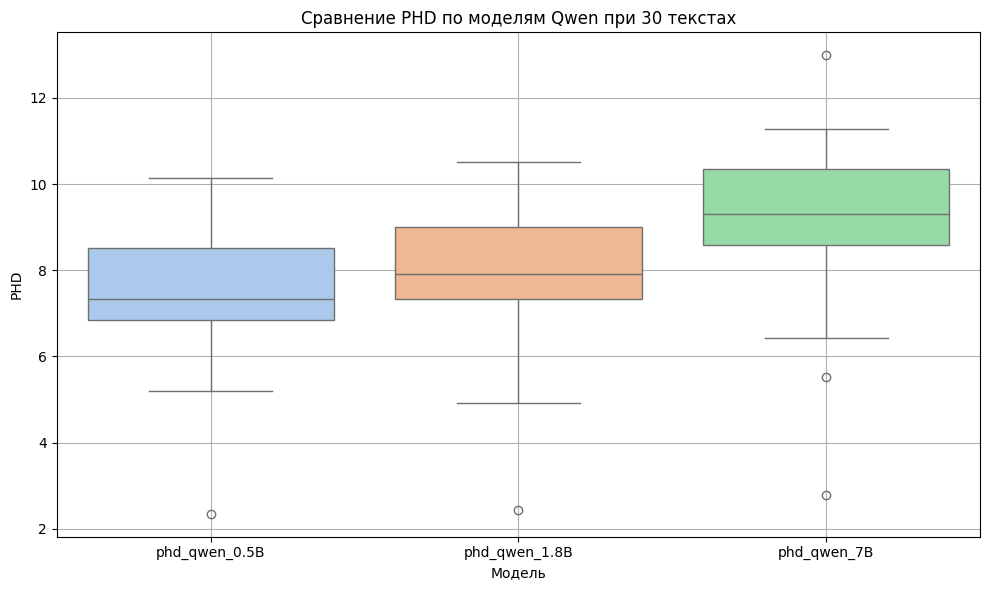

In [ ]:
plt.figure(figsize=(10,6))
phd_columns = ['phd_qwen_0.5B', 'phd_qwen_1.8B', 'phd_qwen_7B']
df_long = df_big_model[phd_columns].melt(var_name="Model", value_name="PHD")

sns.boxplot(data=df_long, x="Model", y="PHD", palette="pastel")

plt.title("Сравнение PHD по моделям Qwen при 30 текстах")
plt.xlabel("Модель")
plt.ylabel("PHD")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
value = np.mean(
    (df_big_model["phd_qwen_7B"] > df_big_model["phd_qwen_1.8B"]) &
    (df_big_model["phd_qwen_1.8B"] > df_big_model["phd_qwen_0.5B"])
)

print(f"Часть текстов, где phd строго растет при росте мощности модели (30 текстов на 0.5, 1.8, 7B): {value: .2f}")

value = np.mean(
    df_subset["phd_qwen_1.8B"] > df_subset["phd_qwen_0.5B"]
)

print(f"Часть текстов, где phd при 1.8 больше 0.5 на 300 текстах: {value: .2f}")

Часть текстов, где phd строго растет при росте мощности модели (30 текстов на 0.5, 1.8, 7B):  0.93
Часть текстов, где phd при 1.8 больше 0.5 на 300 текстах:  0.99


/tmp/ipykernel_3020824/3410855163.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_temp, df_extra], ignore_index=True)


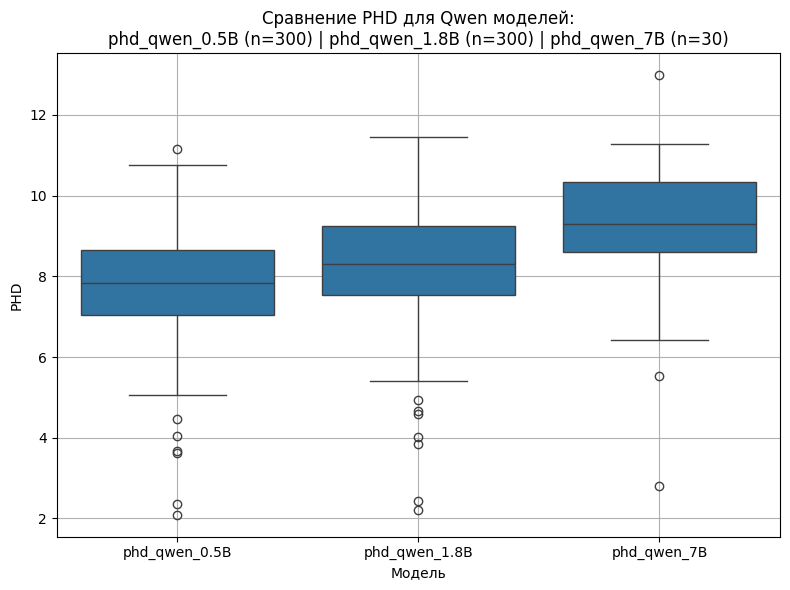

In [15]:
df_temp = df_subset[['phd_qwen_0.5B', 'phd_qwen_1.8B']].copy()
df_temp['phd_qwen_7B'] = pd.NA

df_extra = pd.DataFrame({
    'phd_qwen_0.5B': [pd.NA] * len(df_big_model),
    'phd_qwen_1.8B': [pd.NA] * len(df_big_model),
    'phd_qwen_7B': df_big_model['phd_qwen_7B'].values
})

df_combined = pd.concat([df_temp, df_extra], ignore_index=True)

df_long = df_combined.melt(var_name='Model', value_name='PHD').dropna()

counts = df_long['Model'].value_counts().to_dict()
title = "Сравнение PHD для Qwen моделей:\n"
title += " | ".join([f"{model} (n={counts[model]})" for model in sorted(counts)])

plt.figure(figsize=(8, 6))
sns.boxplot(x='Model', y='PHD', data=df_long)
plt.title(title)
plt.xlabel("Модель")
plt.ylabel("PHD")
plt.grid(True)
plt.tight_layout()
plt.show()